## EMGfromLFP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xarray as xr

In [4]:
from neurodsp.plts.time_series import plot_time_series

In [96]:
from ecephys.emg_from_lfp import compute_EMG
from ecephys.data import channel_groups, paths
from ecephys.sglx_utils import load_timeseries
from ecephys.scoring import load_visbrain_hypnogram
from ecephys.plot import plot_hypnogram_overlay

In [6]:
start_time = 0
end_time = 600
bin_path = Path(paths.lfp_bin["SR"]["Doppio"])

In [7]:
hypno_path = Path(paths.hypnograms["SR"]["Doppio"])
hypno = load_visbrain_hypnogram(hypno_path)

In [95]:
emg_chans = channel_groups.emg["Doppio"]
emg_sig = load_timeseries(bin_path, emg_chans, start_time=start_time, end_time=end_time, xarray=True)

nChan: 385, nFileSamp: 18000019


In [97]:
emg_opts = dict(target_sf=20, window_size=10.0, wp=[300, 600], ws=[275, 625], gpass=1, gstop=60, ftype='butter')
emg_values = compute_EMG(emg_sig.values.T, emg_sig.fs, **emg_opts).T

Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 10.0, LFP sf=2500.0025140000002, LFP nchans = 3




Done!


In [104]:
emg_times = np.linspace(np.min(emg_sig.time), np.max(emg_sig.time), len(emg_values)) + start_time

In [122]:
emg = xr.DataArray(emg_values.flatten(), dims="time", coords={"time": emg_times})
emg.attrs['long_name'] = 'EMG'
emg.attrs['units'] = 'zero-lag correlation'
for key in emg_opts:
    emg.attrs[key] = emg_opts[key]

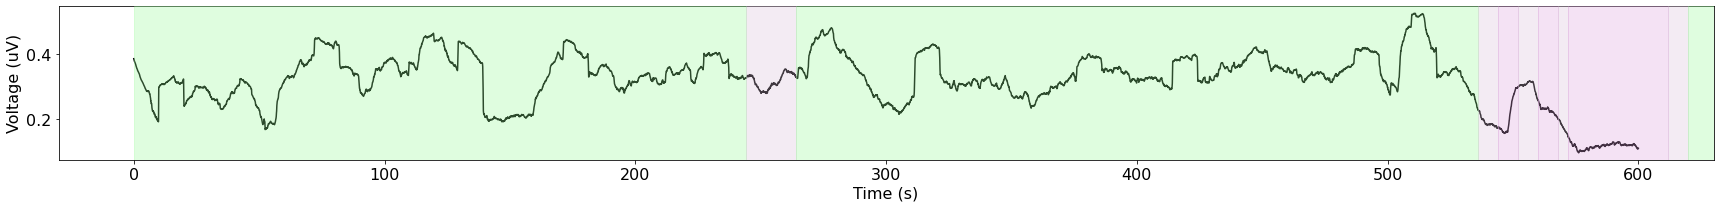

In [123]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(emg.time.values, emg.values, ax=ax)
plot_hypnogram_overlay(hypno, ax=ax)

### Save

In [126]:
emg_ds = xr.Dataset({"emg": emg})

In [128]:
emg_ds.to_netcdf(paths.emg["SR"]["Doppio"])